正在定义特定于类别的增强器...
正在从原始数据集中加载样本并应用增强...
将按照此顺序绘制: ['ModerateDemented', 'MildDemented', 'VeryMildDemented', 'NonDemented']


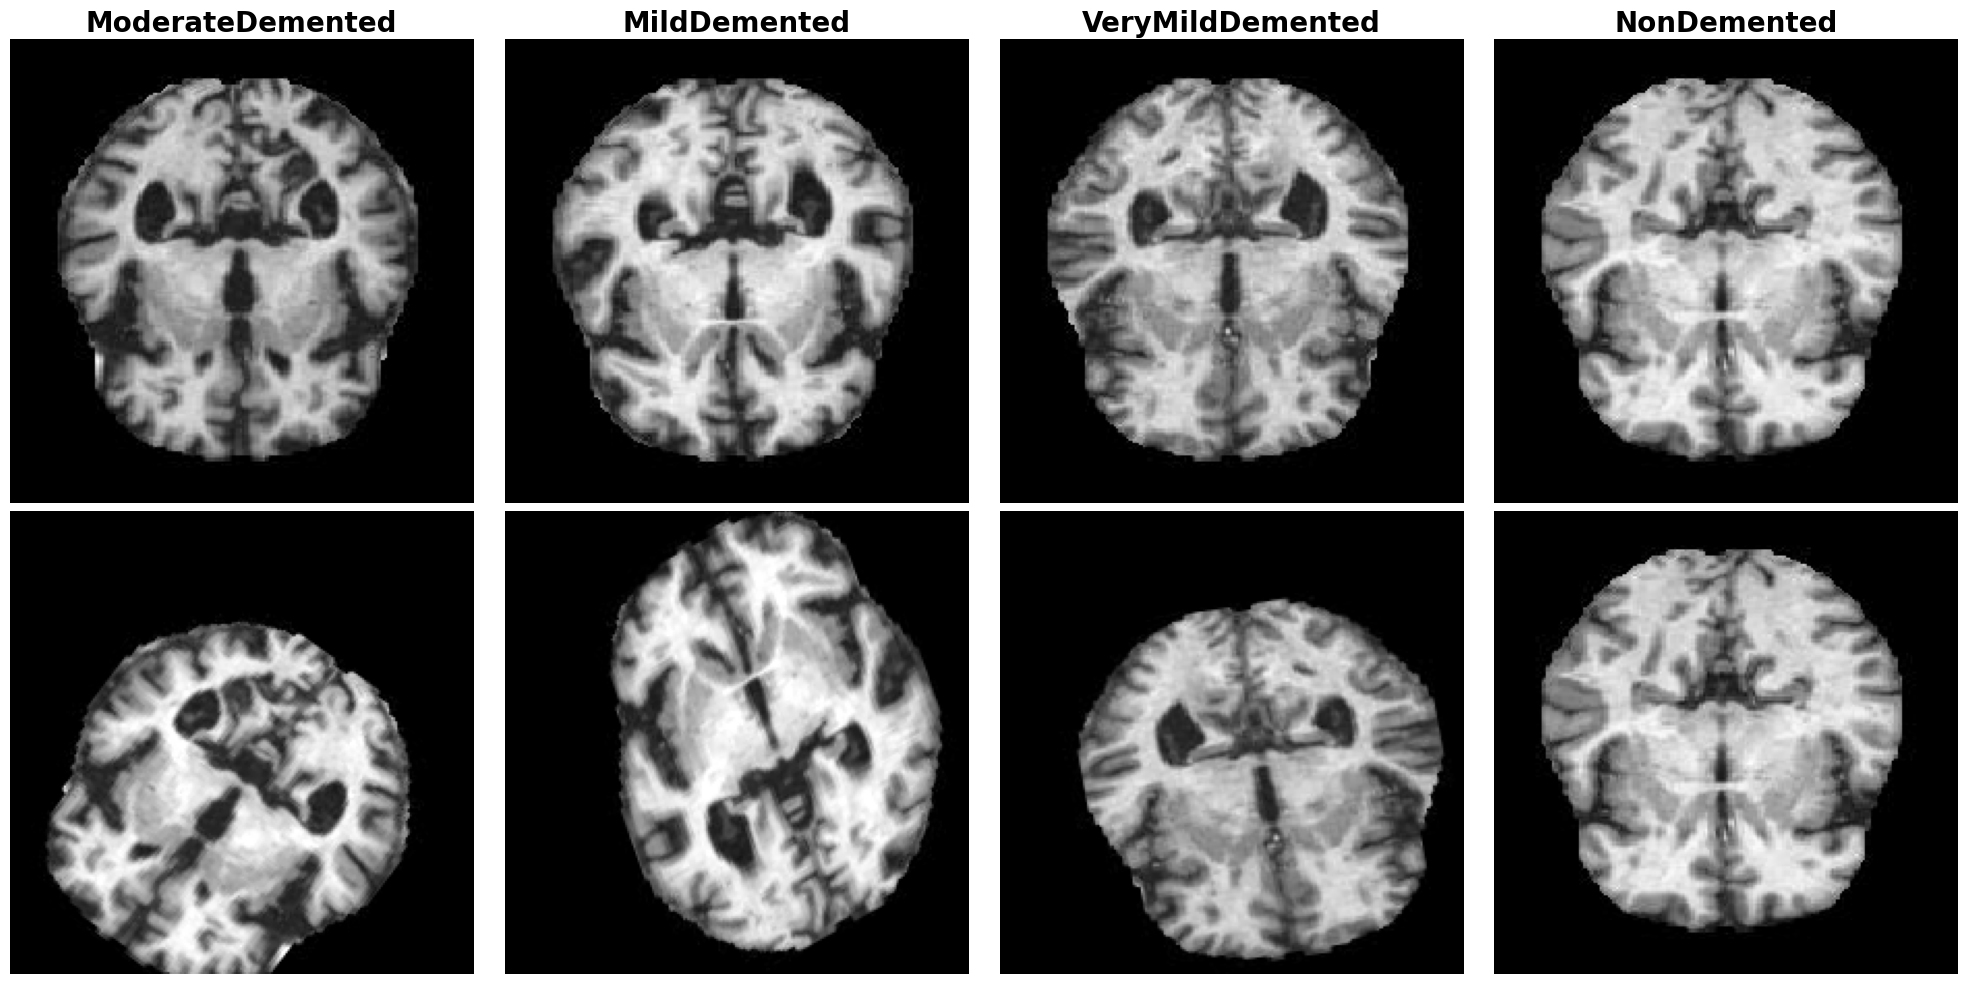

In [8]:
# =S=================================================================
# 单元格: 绘制数据集样本与对应增强示例图 (2x4 网格, 自定义排序)
# ===================================================================
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# --- 1. 定义增强器 ---
moderate_datagen = ImageDataGenerator(
    rotation_range=45, 
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.6, 1.4]
)

mild_datagen = ImageDataGenerator(
    rotation_range=30, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

very_mild_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

non_demented_datagen = ImageDataGenerator() # 不增强

# --- 2. 定义路径和类别 ---

ORIGINAL_DATA_DIR = "/kaggle/input/alzheimer-mri-4-classes-dataset/Alzheimer_MRI_4_classes_dataset"
IMG_HEIGHT = 224
IMG_WIDTH = 224

categories_to_plot = [
    ("ModerateDemented", "ModerateDemented", moderate_datagen), # (MOD)
    ("MildDemented", "MildDemented", mild_datagen),                 # (MD)
    ("VeryMildDemented", "VeryMildDemented", very_mild_datagen),    # (VMD)
    ("NonDemented", "NonDemented", non_demented_datagen)            # (ND)
]


# --- 3. 绘制 2x4 网格 ---
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

print("正在从原始数据集中加载样本并应用增强...")
print(f"按顺序绘制: {[title for title, _, _ in categories_to_plot]}")

for i, (title_name, folder_name, datagen) in enumerate(categories_to_plot):
    class_path = os.path.join(ORIGINAL_DATA_DIR, folder_name)
    if not os.path.isdir(class_path):
        print(f"错误: 找不到目录 {class_path}，跳过。")
        continue
        
    images_in_class = sorted([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
    if not images_in_class:
        print(f"错误: 类别 '{folder_name}' 目录为空，跳过。")
        continue

    original_img_path = os.path.join(class_path, images_in_class[0])

    ax_orig = axes[0, i] 
    img = load_img(original_img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

    img_array = img_to_array(img)
    
    ax_orig.imshow(img_array.astype('uint8')) 
    ax_orig.set_title(title_name, fontsize=20, fontweight='bold') 
    ax_orig.axis('off')

    ax_aug = axes[1, i] 
    img_batch = np.expand_dims(img_array, axis=0)
    
    augmented_iterator = datagen.flow(img_batch, batch_size=1)
    augmented_img = next(augmented_iterator)[0] 
    
    ax_aug.imshow(augmented_img.astype('uint8'))
    ax_aug.axis('off')

    if i == 0: 
        ax_orig.set_ylabel("Original Image\n(from source dataset)", fontsize=18, fontweight='bold', labelpad=20)
        ax_aug.set_ylabel("Augmented Image\n(generated in code)", fontsize=18, fontweight='bold', labelpad=20)


plt.tight_layout(pad=1.5)
plt.savefig('dataset_augmentation_preview.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow import keras
from keras import layers
import matplotlib.image as img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 抑制警告

Data Load

In [ ]:
import shutil

def augment_images(input_dir, output_dir, target_count, datagen):
    if os.path.exists(output_dir):
     shutil.rmtree(output_dir)
    
    # 1. 创建输出目录（如果不存在）
    os.makedirs(output_dir, exist_ok=True)
    
    existing_files = os.listdir(input_dir)
    
    existing_count = len(existing_files)
   
    
    # 2. 复制原始图像到输出目录（避免重复）
    for filename in existing_files:
        src_path = os.path.join(input_dir, filename)
        dst_path = os.path.join(output_dir, filename)
        if not os.path.exists(dst_path):  # 避免覆盖已有文件
         shutil.copy(src_path, dst_path)#将原始图像从 src_path复制到 dst_path
   
    
    
    # 3.计算需要生成的增强图像数量
    current_count = len(os.listdir(output_dir))  # 当前总数量（含原始）
    copies_needed = (target_count - current_count 
                     + len(existing_files) - 1) // current_count  
    
    if copies_needed==0:
        return
    # 4. 生成增强图像
    for filename in existing_files:
        img_path = os.path.join(input_dir, filename)
        img = Image.open(img_path)#使用PIL库，打开当前特定图片
        img_array = np.array(img)

        # 扩展维度以符合Keras的输入要求 (height, width, channels)
        if len(img_array.shape) == 2:  # 灰度图像
            img_array = np.expand_dims(img_array, axis=-1)
            img_array = np.repeat(img_array, 3, axis=-1)  # 转换为3通道
        
        img_array = np.expand_dims(img_array, axis=0)  # 添加batch维度
        # 生成增强图像直到满足目标数量
        ##对当前原始图片生成多次增强版本，比如3200/64=50次
        i = 0
        for batch in datagen.flow(img_array, batch_size=1):
            if current_count >= target_count:
                break
                
            augmented_img = batch[0].astype('uint8')
            if augmented_img.shape[-1] == 3:  # 转换回灰度
                augmented_img = augmented_img.mean(axis=-1).astype('uint8')
            
            save_path = os.path.join(output_dir, f"aug_{i}_{filename}")
            Image.fromarray(augmented_img).save(save_path)
            current_count += 1
            i += 1
            
            if i >= copies_needed:
                break

In [ ]:
# 定义不同类别的增强配置
moderate_datagen = ImageDataGenerator(
    rotation_range=45, # 随机旋转角度范围(±45度)
    width_shift_range=0.3,#水平平移范围(30%宽度)
    height_shift_range=0.3,
    shear_range=0.2, # 剪切变换强度
    zoom_range=0.2,# 随机缩放范围(80%-120%)
    horizontal_flip=True,# 允许水平翻转
    fill_mode='nearest',# 填充新像素的方式(最近邻)
    brightness_range=[0.6, 1.4]  # 亮度调整
)

mild_datagen = ImageDataGenerator(
    rotation_range=30, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

very_mild_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

non_demented_datagen = ImageDataGenerator()  # 基本不增强

In [ ]:
'''对数据集图像不足的部分做数据增强处理'''

# 原始数据路径
base_dir = '../input/alzheimer-mri-4-classes-dataset/Alzheimer_MRI_4_classes_dataset'
baseout_dir = './augmented_data'  
os.makedirs(baseout_dir, exist_ok=True)


# 分别增强四类数据
augment_images(
    input_dir=os.path.join(base_dir, 'ModerateDemented'),
    output_dir=os.path.join(baseout_dir, 'ModerateDemented'),
    target_count=3200,
    datagen=moderate_datagen
)

augment_images(
    input_dir=os.path.join(base_dir, 'MildDemented'),
    output_dir=os.path.join(baseout_dir, 'MildDemented'),
    target_count=3200,
    datagen=mild_datagen
)

augment_images(
    input_dir=os.path.join(base_dir, 'VeryMildDemented'),
    output_dir=os.path.join(baseout_dir, 'VeryMildDemented'),
    target_count=3200,
    datagen=very_mild_datagen
)

augment_images(
    input_dir=os.path.join(base_dir, 'NonDemented'),
    output_dir=os.path.join(baseout_dir, 'NonDemented'),
    target_count=3200,
    datagen=non_demented_datagen
)

print("Data augmentation completed!")

In [ ]:
'''
print("正在压缩数据集...")
!cd /kaggle/working
!zip -qr augmented_data.zip augmented_data
print("压缩完成！文件保存为 augmented_data.zip")